# Model selection
The topology of an artificial neural network has to be optimized to obtain the model wich generalizes the best. This notebook is an introduction to the process of model selection. During this laboratory, you will be able to learn how to use the tools for empirically finding the best topology of an artificial neural network and the parameters of the learning algorithm.

## Loading the packages

In [100]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
import os
import pandas as pd
from sklearn.model_selection import train_test_split
# %pip install tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

import mlp_backprop_momentum as mlp

import k_fold_cross_validation as cv

%matplotlib inline

## The dataset
This function creates a dataset with two classes in two dimensions. It has two parameters: the size of the dataset and the spread of each one of the classes. A high spread value makes both classes to superpose, making the classification more difficult.

In [2]:
def create_dataset(n, s):
    n1 = int(np.ceil(n / 2.0))
    n2 = int(np.floor(n / 2.0))
    x1 = np.random.normal(-1, s, n1)
    y1 = np.random.uniform(-1, 1,  n1)
    x2 = np.random.normal(1, s, n2)
    y2 = np.random.uniform(-1, 1, n2)
    return np.stack((np.concatenate((x1, x2)), np.concatenate((y1, y2)), np.concatenate((np.ones(n1), -1*np.ones(n2)))), 1)

In [3]:
def plot_dataset(s):
    dataset = create_dataset(200, s)
    pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
    pl.xlim(-3,3)
    pl.ylim(-1,1)
    pl.grid()

In [4]:
interact(plot_dataset, s=widgets.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.01, description='Spread:',));

interactive(children=(FloatSlider(value=0.1, description='Spread:', max=1.0, min=0.1, step=0.01), Output()), _…

## The MLP
Import the code of the backpropagation with momentum algorithm

## Cross-validation
Import the code of the cross-valdidation test

cool


## Dataset
Create a dataset to perform the test

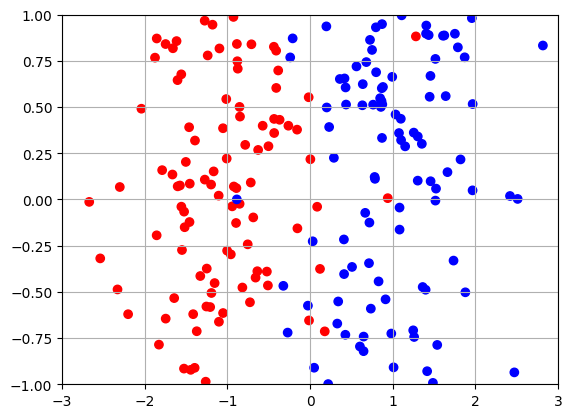

In [7]:
DATASET_SIZE = 200
SPREAD = 0.7
dataset = create_dataset(DATASET_SIZE, SPREAD)

pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
pl.xlim(-3,3)
pl.ylim(-1,1)
pl.grid()

## Exploring the number of epochs
Let's first try to estimate how many iterations of the backpropagation algorithm are enough to find a low training error. We fixed the learning rate to `0.001` and the momentum term to `0.5`. These values are just initial guesses which work well in most of the cases. Feel free to change these values if:

+ the error curve oscillates -> reduce the learning rate
+ the error curve is very smooth and does not change -> increase the learning rate
+ the model does not converge -> try different values of momentum

This initial test is performed by only tracking the training error. Hence, it is impossible to know if the model overfits or not. We will only know if the model's complexity is enough for learning the task.

The following snippet also changes the number of hidden neurons from the simplest model possible (2 neurons) to a model having a complexity you think is excesive. Model selection in artificial neural networks is based on the experience. Moreover, notice that the MLPs are initialized several times to avoid a too bad result due to an unlucky initialization.

In [11]:
N_INITS = 10
EPOCHS = 50
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [12]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([2,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:2], dataset[:,2:3]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


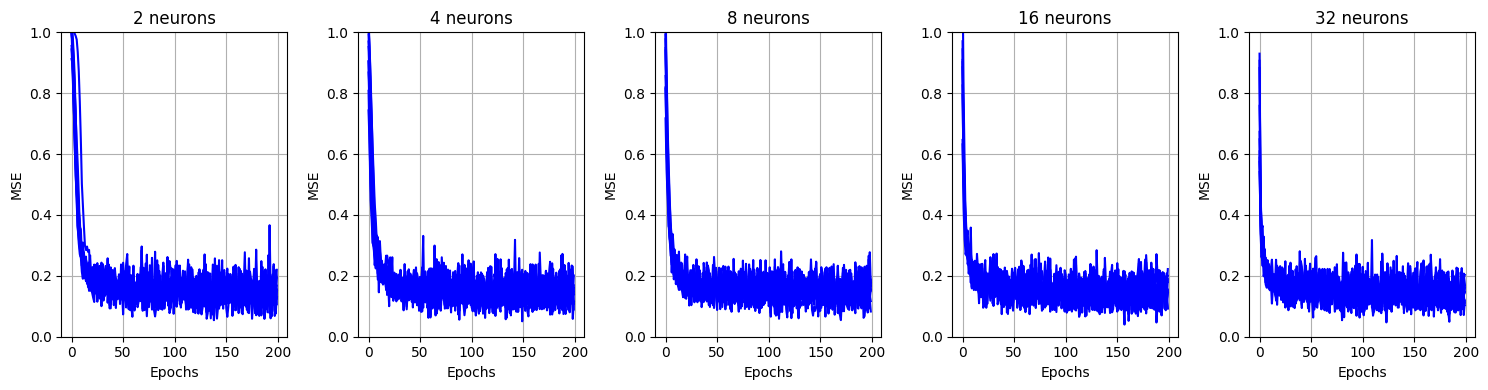

In [13]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In every case, from 2 to 32 neurons in the hidden layer, the training error does not improve anymore after 50 iterations. The result of this test indicates that the minimum number of iterations needed are around 20 iterations (Taking into account only the training error!).

## Exploring the number of hidden neurons
Knowing that there are no significant improvements after 50 iterations, we can now further explore how the complexity of the model (number of hidden neurons) is linked to the generalization performance (test error). The following snippet allows you to explore both the number of epochs and the number of hidden neurons without restarting the training.

In [14]:
EPOCHS = 100
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 8, 16, 32]

In [15]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([2,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


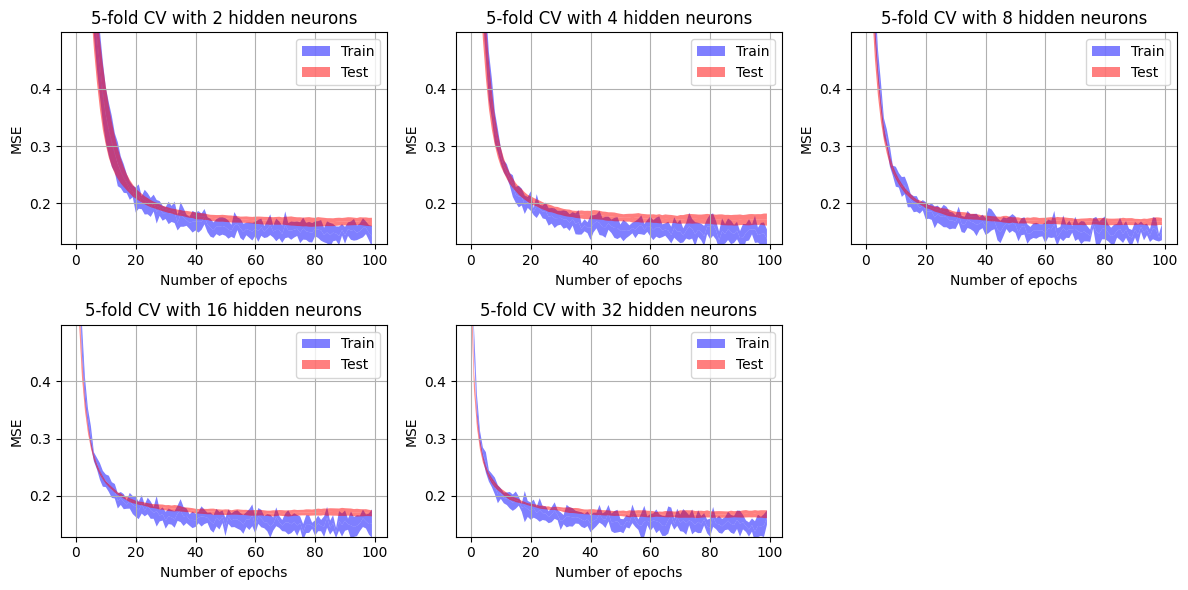

In [16]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

Notice that the test error does not improve much between 40 and 60 iterations, neither adding more hidden neurons after 4 units. 

The following snippet shows a different visualization.

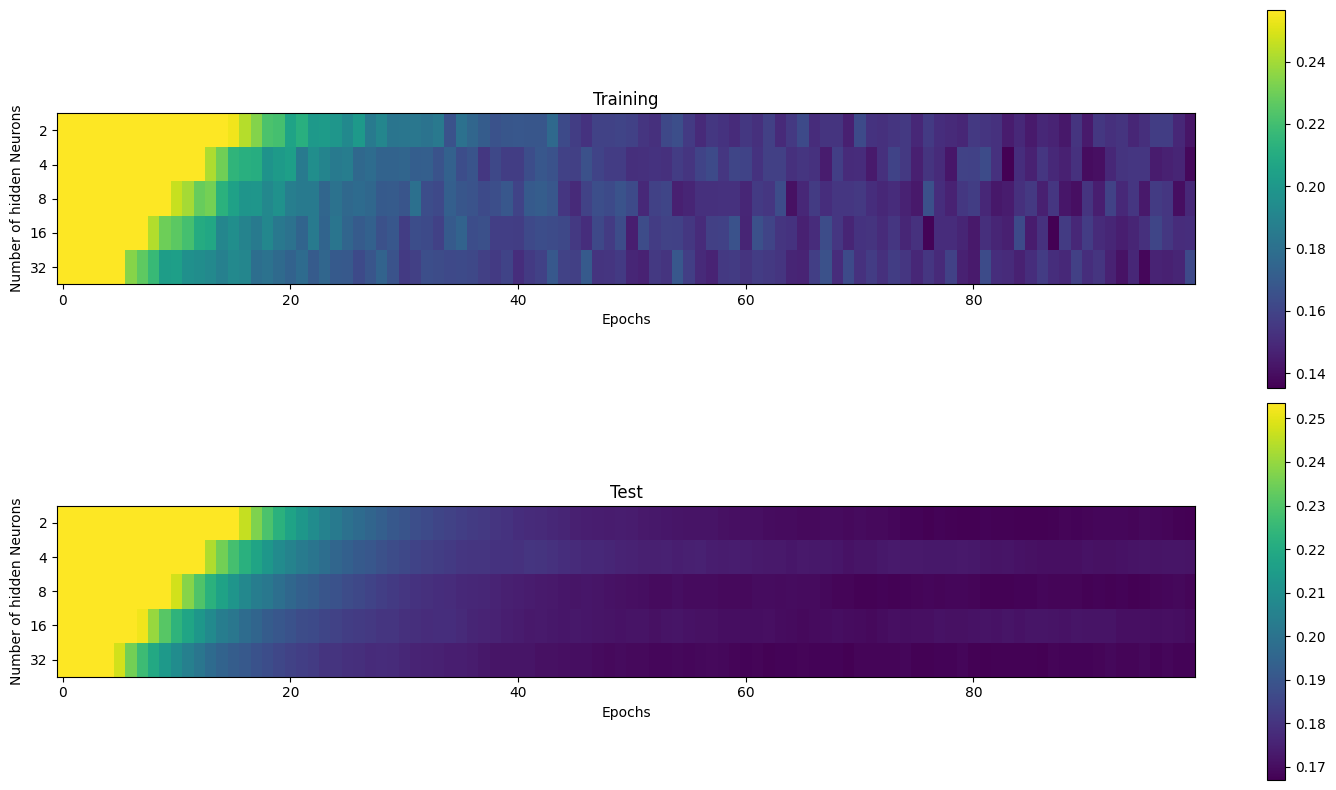

In [17]:
pl.figure(figsize=(15,8))

pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()

pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()

pl.tight_layout()

For this particular problem, having more hidden neurons or running the backpropagation algorithm longer does not affect negatively the performance of the model. However, more iterations implies more processing time and more neurons implies more ressources and this should be avoided.

## The final model
An artificial neural network with 2 neurons and 50 iterations of the backpropagation algorithm is enough to solve the problem.

In [6]:
nn = mlp.MLP([2,2,1], 'tanh')

In [19]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=50,
                                                          threshold=0.0)

In [20]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.16092612645968477
MSE test:  0.17125197336435222
Confusion matrix:
[[96.  4.]
 [ 7. 93.]]


# Mouse dataset

Exercise: Implement a similar pipeline for the dataset of the mouse used last week. Compare the results obtained using a Multilayer Perceptron (MLP) with the results obtained last week using random forests.

Notes/Hints:
- The dataset for the mice has three output classes (w, n, r) instead of two (blue or red). Please use the corresponding class (MLP_N_output_classes) in the `mlp_backprop_momentum.py` file to account for this change.
- You should reduce the number of inits, and the number of epochs, as the mouse dataset is much bigger (In general, reduce the number of combinations that you are testing).
- The dataset should be in a format similar to the following when calling the function *cv.k_fold_cross_validation*: dataset=np.concatenate((X,onehot_encoded_Y),axis=1)
- You should be aware of the class imbalance. Find a way to take that into consideration in order to obtain better results.
- The output (Y) has to be one-hot encoded in order to be compatible with a NN. You can do it like this:

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()

onehot_encoded_Y = label_binarizer.fit_transform(Y)


In [6]:
path = os.path.join(os.getcwd(), 'EEG_mouse_data.csv')
data_mice = pd.read_csv(path)
X = data_mice.drop(['EEGv','state'],axis=1).to_numpy()
X = MinMaxScaler().fit_transform(X)
Y = data_mice['state'].values

# Prepare one-hot encoder
label_binarizer = LabelBinarizer()
label_binarizer.fit(Y)

# Split train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
Y_test = label_binarizer.transform(Y_test)

# Subsample the train set to the least represented class
min_class = np.argmin([(Y_train == c).sum() for c in label_binarizer.classes_])
min_class = label_binarizer.classes_[min_class]

mask = Y_train == min_class
new_x = X_train[mask]
new_y = Y_train[mask]
min_c = len(new_x)
for c in label_binarizer.classes_:
    if c == min_class: continue
    mask = Y_train == c
    new_y = np.concatenate((new_y, Y_train[mask][:min_c]))
    new_x = np.concatenate((new_x, X_train[mask][:min_c]),axis=0)

# One-hot encoding
new_y = label_binarizer.fit_transform(new_y)
train = np.concatenate((new_x, new_y),axis=1)

In [7]:
EPOCHS = 30
K = 5
N_TESTS = 4
N_NEURONS = [32,64]
LEARNING_RATE = 0.001
MOMENTUM=0.5

In [89]:
pbar1 = tqdm(total=len(N_NEURONS))
pbar2 = tqdm()

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
for i_h, h in enumerate(N_NEURONS):  # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP_N_output_classes([X_train.shape[1], h, len(label_binarizer.classes_)], 'tanh')
    pbar2.reset(total=N_TESTS)
    for i in np.arange(N_TESTS):  # looping the tests
        nn.init_weights()  # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,  # notice that we do not use cv.k_fold_cross_validation
                                                            train,  # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,  # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
        pbar2.update(1)
    pbar1.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Testing 64 neurons...
Testing 32 neurons...


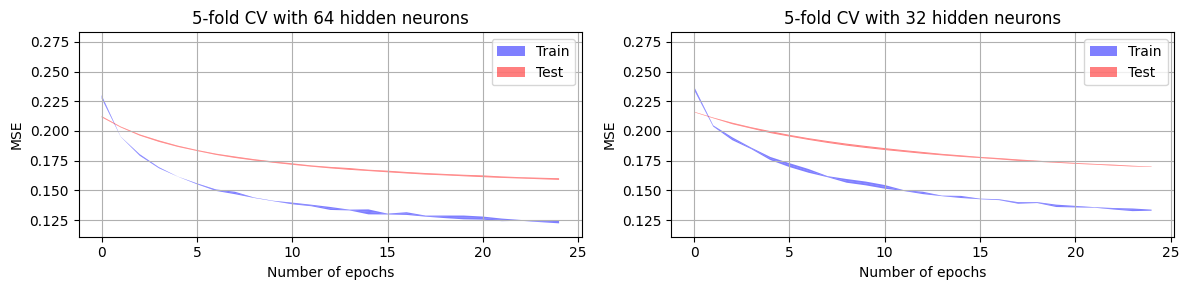

In [90]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(v_min*.9, v_max*1.2)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

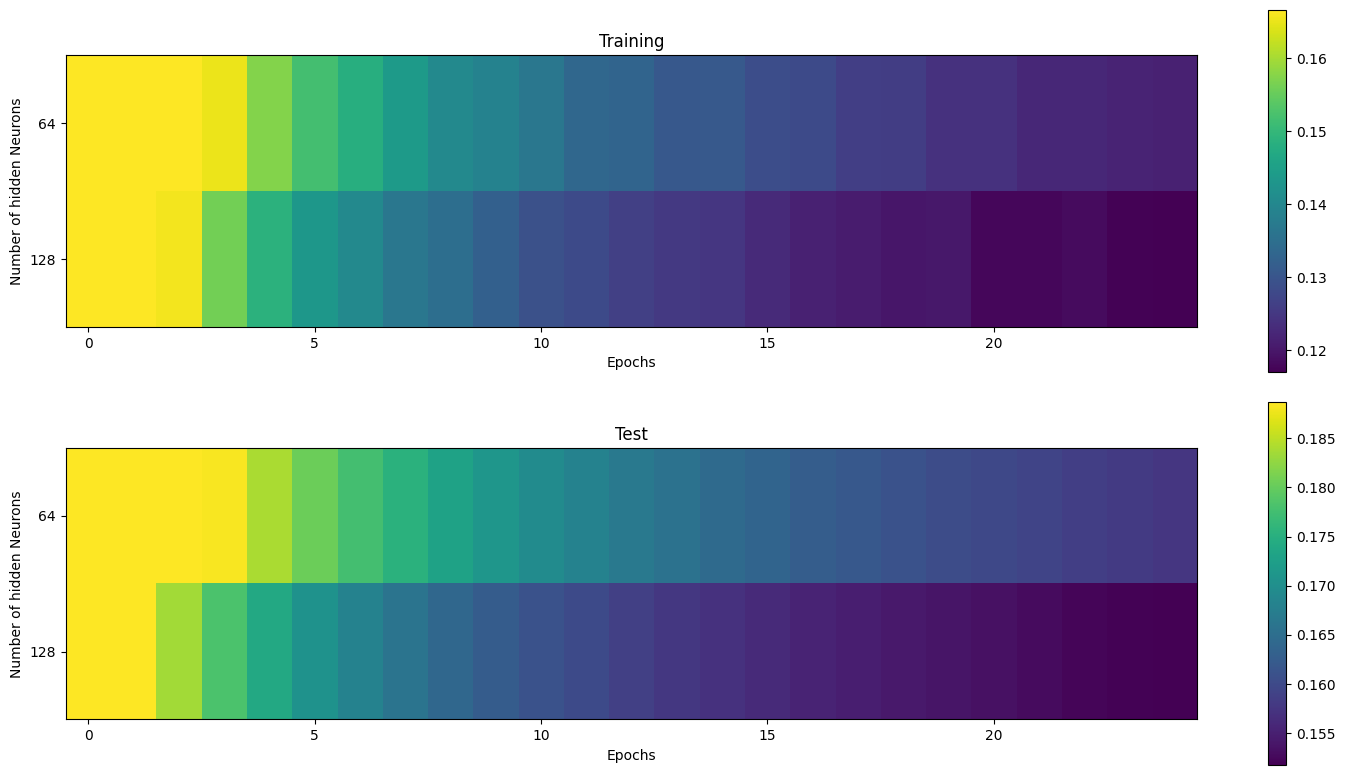

In [86]:
pl.figure(figsize=(15,8))

pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()

pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()

pl.tight_layout()

0.850588876253472


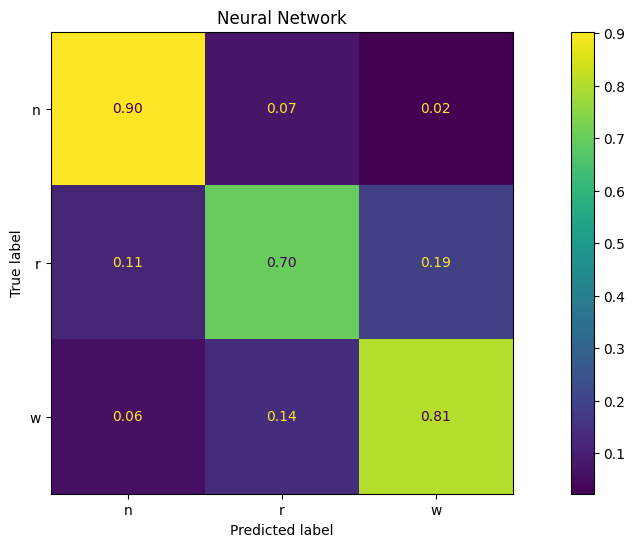

In [91]:
preds = np.argmax(nn.compute_output(X_test), axis=1)
y = np.argmax(Y_test, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

cm_test = confusion_matrix(y, preds, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_binarizer.classes_)
_=disp_test.plot(ax=ax, values_format=".2f")
_=ax.set_title('Neural Network')

print(f1_score(y, preds, average='weighted'))

# Final model

In [8]:
EPOCHS = 50
K = 5
N_NEURONS = 32
LEARNING_RATE = 0.001
MOMENTUM=0.5

nn = mlp.MLP([X_train.shape[1], N_NEURONS, len(label_binarizer.classes_)], 'tanh')
nn.init_weights()
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                           train,
                                                           k=K,
                                                           learning_rate=LEARNING_RATE,
                                                           momentum=MOMENTUM,
                                                           epochs=EPOCHS,
                                                           threshold=0.0)

F1-score : 0.8674382962170619
Accuracy : 0.851431391905232


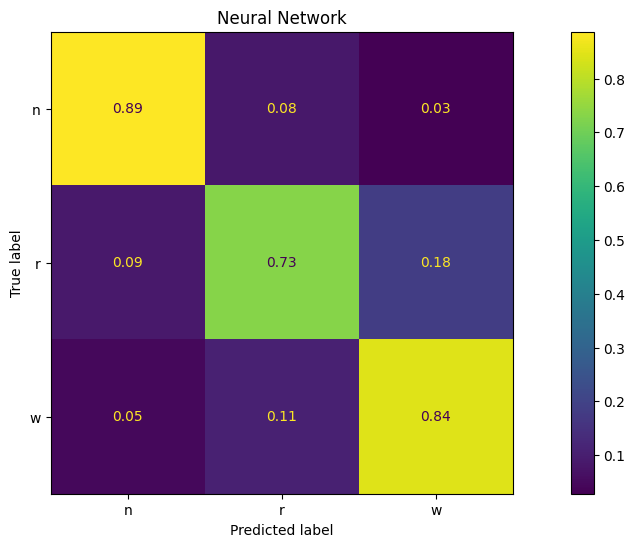

In [102]:
preds = np.argmax(nn.compute_output(X_test), axis=1)
y = np.argmax(Y_test, axis=1)

_, ax = plt.subplots(1, 1, figsize=(15, 6))

cm_test = confusion_matrix(y, preds, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_binarizer.classes_)
_=disp_test.plot(ax=ax, values_format=".2f")
_=ax.set_title('Neural Network')

print(f"F1-score : {f1_score(y, preds, average='weighted')}")
print(f"Accuracy : {accuracy_score(y, preds)}")